In [1]:
# !pip install -e git+https://github.com/maho3/ltu-ili#egg=ltu-ili
# !pip install "ltu-ili[pytorch]"
# !black drive/MyDrive/classes/STCS6701/final_project/final.ipynb

ili is a package based on (sbi, pydelfi, and lampe) : https://github.com/maho3/ltu-ili/tree/main

In [2]:
import torch
import torch.nn as nn

import ili
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

# from ili.dataloaders import NumpyLoader
# from ili.inference import InferenceRunner

import numpy as np
import matplotlib.pyplot as plt


plt.rcParams.update(
    {
        "text.usetex": False,
        # "font.family": "Helvetica",
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "font.size": 11,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "ytick.right": True,
        "xtick.top": True,
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "xtick.minor.size": 2,
        "ytick.minor.size": 2,
    }
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


this was ran in google collab for GPU resources

In [3]:
# from google.colab import drive
# drive.mount("/content/drive")
# !ls

In [4]:
# !cd drive/MyDrive/classes/STCS6701/final_project

In [5]:
# !curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/IllustrisTNG/Maps_T_IllustrisTNG_LH_z=0.00.npy -o ./data/Maps_T_IllustrisTNG_LH_z=0.00.npy
# !curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/IllustrisTNG/Maps_Mgas_IllustrisTNG_LH_z=0.00.npy -o ./data/Maps_Mgas_IllustrisTNG_LH_z=0.00.npy

dowload the corresponding variables that generated the data above

In [6]:
# !curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/IllustrisTNG/params_LH_IllustrisTNG.txt -o ./data/params_LH_IllustrisTNG.txt

now load the data and param pairs

In [ ]:
# log scale  for more information
# temp_data_path = "drive/MyDrive/classes/STCS6701/final_project/data/Maps_T_IllustrisTNG_LH_z=0.00.npy"
# gas_mass_data_path = "drive/MyDrive/classes/STCS6701/final_project/data/Maps_Mgas_IllustrisTNG_LH_z=0.00.npy"
# params_data_path = (
#     "drive/MyDrive/classes/STCS6701/final_project/data/params_LH_IllustrisTNG.txt"
# )

temp_data_path = "/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/2D_maps/data/IllustrisTNG/Maps_T_IllustrisTNG_LH_z=0.00.npy"
gas_mass_data_path = "/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/2D_maps/data/IllustrisTNG/Maps_Mgas_IllustrisTNG_LH_z=0.00.npy"
params_data_path = "/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/2D_maps/data/IllustrisTNG/params_LH_IllustrisTNG.txt"

In [8]:
x_temp = np.log10(np.load(temp_data_path))
x_gas_mass = np.log10(np.load(gas_mass_data_path))
theta = np.loadtxt(params_data_path)

In [9]:
theta = np.repeat(theta, 15, axis=0)  # recall each simulation has 15 images
theta_labels = [
    r"$\Omega_m$",
    r"$\sigma_8$",
    r"$A_{SN1}$",
    r"$A_{AGN1}$",
    r"$A_{SN2}$",
    r"$A_{AGN2}$",
]

In [10]:
print(x_temp.shape)
print(x_gas_mass.shape)
print(theta.shape)

(15000, 256, 256)
(15000, 256, 256)
(15000, 6)


In [11]:
x_temp = x_temp[:, None, ...]
x_gas_mass = x_gas_mass[:, None, ...]

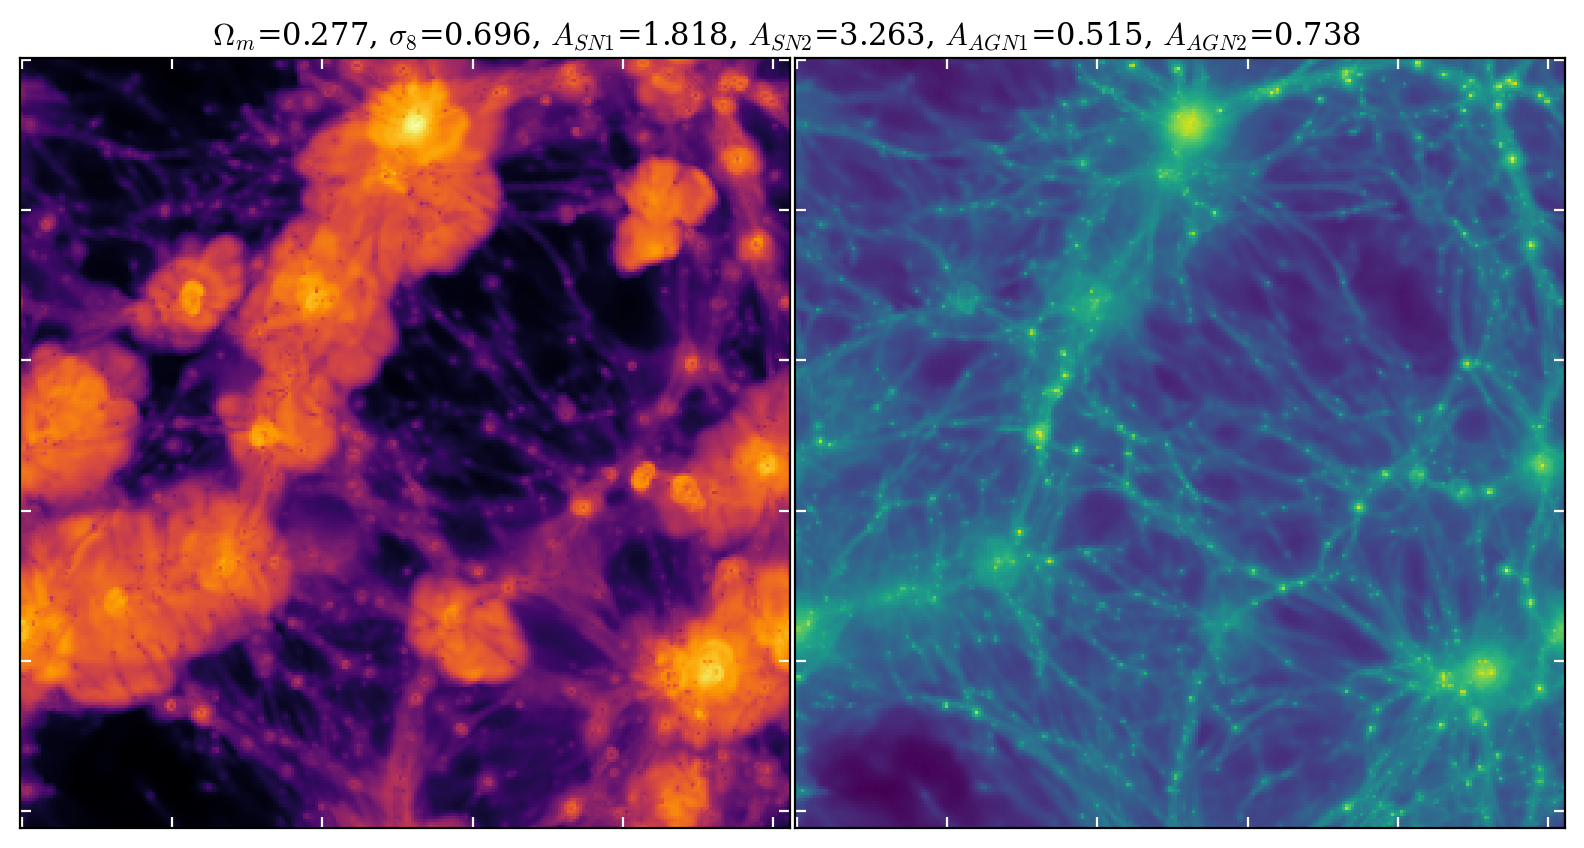

In [12]:
# visualize a random temp and density field
random = np.random.randint(0, x_temp.shape[0])
fig, ax = plt.subplots(1, 2, dpi=200, figsize=(10, 5))
plt.subplots_adjust(wspace=0.0, hspace=0.05)
ax[0].imshow(x_temp[random][0], cmap="inferno")
ax[1].imshow(x_gas_mass[random][0], cmap="viridis")
ax[0].text(
    0.25,
    1.05,
    r"$\Omega_m$="
    + f"{theta[random][0]:.3f}, "
    + r"$\sigma_8$="
    + f"{theta[random][1]:.3f}"
    + r", $A_{{SN1}}$="
    + f"{theta[random][2]:.3f}"
    + r", $A_{{SN2}}$="
    + f"{theta[random][3]:.3f}"
    + r", $A_{{AGN1}}$="
    + f"{theta[random][4]:.3f}"
    + r", $A_{{AGN2}}$="
    + f"{theta[random][5]:.3f}",
    ha="left",
    va="top",
    transform=ax[0].transAxes,
)

# another_random = np.random.randint(0, x_temp.shape[0])
# ax[2].imshow(x_temp[another_random][0], cmap="inferno")
# ax[3].imshow(x_gas_mass[another_random][0], cmap="viridis")

for i in range(2):
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    # set ticks to white
    ax[i].tick_params(axis="both", which="both", colors="white")
plt.savefig("./random_temp_gasmass.png", bbox_inches="tight", dpi=300, pad_inches=0.1)
plt.show()

In [19]:
# make a dataloader
temp_loader = ili.dataloaders.NumpyLoader(
    x=x_temp, theta=theta
)  # splits data into train and val
gas_mass_loader = ili.dataloaders.NumpyLoader(x=x_gas_mass, theta=theta)

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=8, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out


embedding_CNN = CNN()

In [17]:
# determine prior bounds
prior_min = theta.min(axis=0)
prior_max = theta.max(axis=0)
prior = ili.utils.Uniform(low=prior_min, high=prior_max, device=device)

In [ ]:
# networks to be used, can combine, but let's try one by one
nets = [
    ili.utils.load_nde_sbi(
        engine="NPE",
        model="maf",
        hidden_features=50,
        num_transforms=5,
        embedding_net=embedding_CNN,
    ),
]

# define training arguments
train_args = {
    "training_batch_size": 32,
    "learning_rate": 5e-5,
    "stop_after_epochs": 50,
}

# initialize the trainer
temperature_runner = ili.inference.InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir="./temp_model",
)

# train the model on temperature this outputs a posterior model and training logs
posterior_ensemble_temp, summaries_temp = temperature_runner(loader=temp_loader)

/mnt/home/fgarcia/py_venves/camels/lib/python3.9/site-packages/sbi/neural_nets/factory.py:332: UserWarning: The passed embedding net will be moved to cpu for
                        constructing the net building function.
  check_net_device(embedding_net, "cpu", embedding_net_warn_msg),
INFO:root:MODEL INFERENCE CLASS: NPE
/mnt/home/fgarcia/py_venves/camels/lib/python3.9/site-packages/sbi/inference/trainers/npe/npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/mnt/home/fgarcia/py_venves/camels/lib/python3.9/site-packages/sbi/inference/trainers/npe/npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
INFO:root:Training model 1 / 1.


 Training neural network. Epochs trained: 316

/mnt/home/fgarcia/py_venves/camels/lib/python3.9/site-packages/sbi/inference/posteriors/ensemble_posterior.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 1207.3950464725494 seconds to train models.
INFO:root:Saving model to temp_model


 Neural network successfully converged after 317 epochs.

In [48]:
summaries_temp

[{'epochs_trained': [0, 317],
  'best_validation_loss': [inf, -0.9721521923075551],
  'validation_loss': [3.5207855701446533,
   2.574375598326973,
   2.5013544144837754,
   2.4786465478980024,
   2.392518002053966,
   2.2888398896092954,
   2.2319831951804785,
   2.1337907728941543,
   2.1030037454936816,
   2.069816555665887,
   2.0486006607180056,
   2.021912745807482,
   1.967280307541723,
   1.9248763115509697,
   1.950777266336524,
   1.9149436432382334,
   1.9438593439433887,
   1.8588050448376199,
   1.8164286535719167,
   1.749390502338824,
   1.7325554153193599,
   1.6814249676206838,
   1.7027782253597095,
   1.5692585654880689,
   1.5408024658327517,
   1.3147147764330325,
   1.0804529190063477,
   0.9515979996194011,
   0.9075937980543012,
   0.7875780686736107,
   0.7636843223286711,
   0.7350364962349767,
   0.6143890327733496,
   0.5806373808047046,
   0.5022726078396258,
   0.4442604478934537,
   0.4152477652482364,
   0.3414327583235243,
   0.34152258641046024,
   0.2

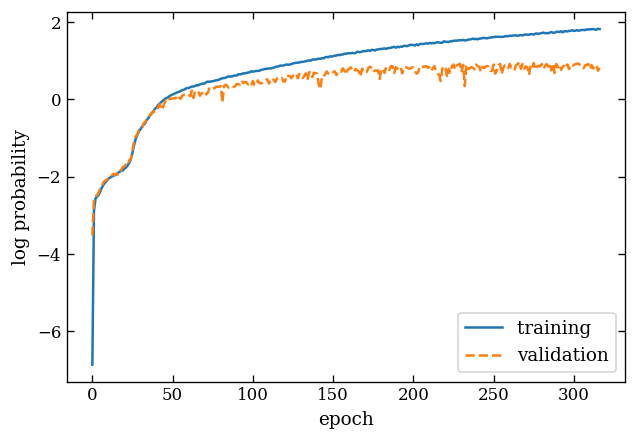

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=120)

for i, m in enumerate(summaries_temp):
    ax.plot(m["training_log_probs"], ls="-", label=f"training ")
    ax.plot(m["validation_log_probs"], ls="--", label=f"validation")

ax.set_xlabel("epoch")
ax.set_ylabel("log probability")
ax.set_xlim(0, None)
ax.legend()

plt.savefig("./maf_log_prob_temp.png", bbox_inches="tight", dpi=300, pad_inches=0.1)
plt.show()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

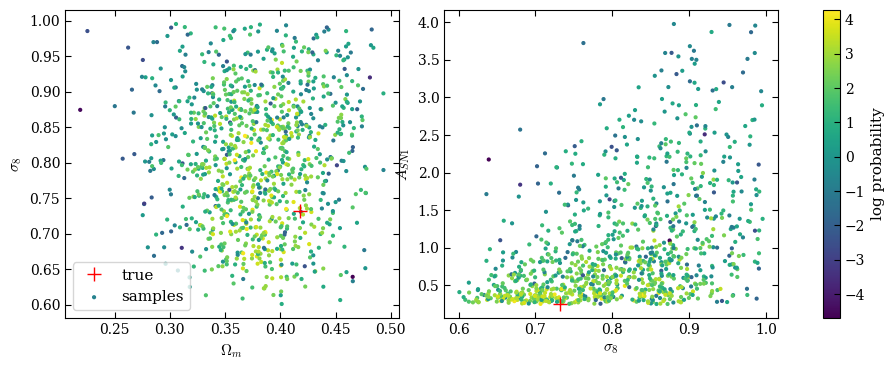

In [ ]:
# choose a random input
ind = np.random.randint(len(theta))
x_temp_test = torch.Tensor(x_temp[ind]).to(device)

# generate samples from the posterior using accept/reject sampling
samples = posterior_ensemble_temp.sample((1000,), x_temp_test)
# calculate the log_prob for each sample
log_prob = posterior_ensemble_temp.log_prob(samples, x_temp_test)

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

# plot the posterior samples and the true value
labels = [
    r"$\Omega_m$",
    r"$\sigma_8$",
    r"$A_{SN1}$",
    r"$A_{AGN1}$",
    r"$A_{SN2}$",
    r"$A_{AGN2}$",
]
fig, axs = plt.subplots(
    1, 3, figsize=(10, 4), gridspec_kw={"width_ratios": [1, 1, 0.05]}
)
plt.subplots_adjust(wspace=0.2)
for i in range(2):
    axs[i].plot(theta[ind, i], theta[ind, i + 1], "r+", markersize=10, label="true")
    im = axs[i].scatter(
        samples[:, i], samples[:, i + 1], c=log_prob, s=4, label="samples"
    )
    axs[i].set_xlabel(labels[i])
    axs[i].set_ylabel(labels[i + 1])
axs[0].legend()
plt.colorbar(im, label="log probability", use_gridspec=True, cax=axs[2])
plt.savefig(
    "./maf_posterior_sample_temp.png", bbox_inches="tight", dpi=300, pad_inches=0.1
)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

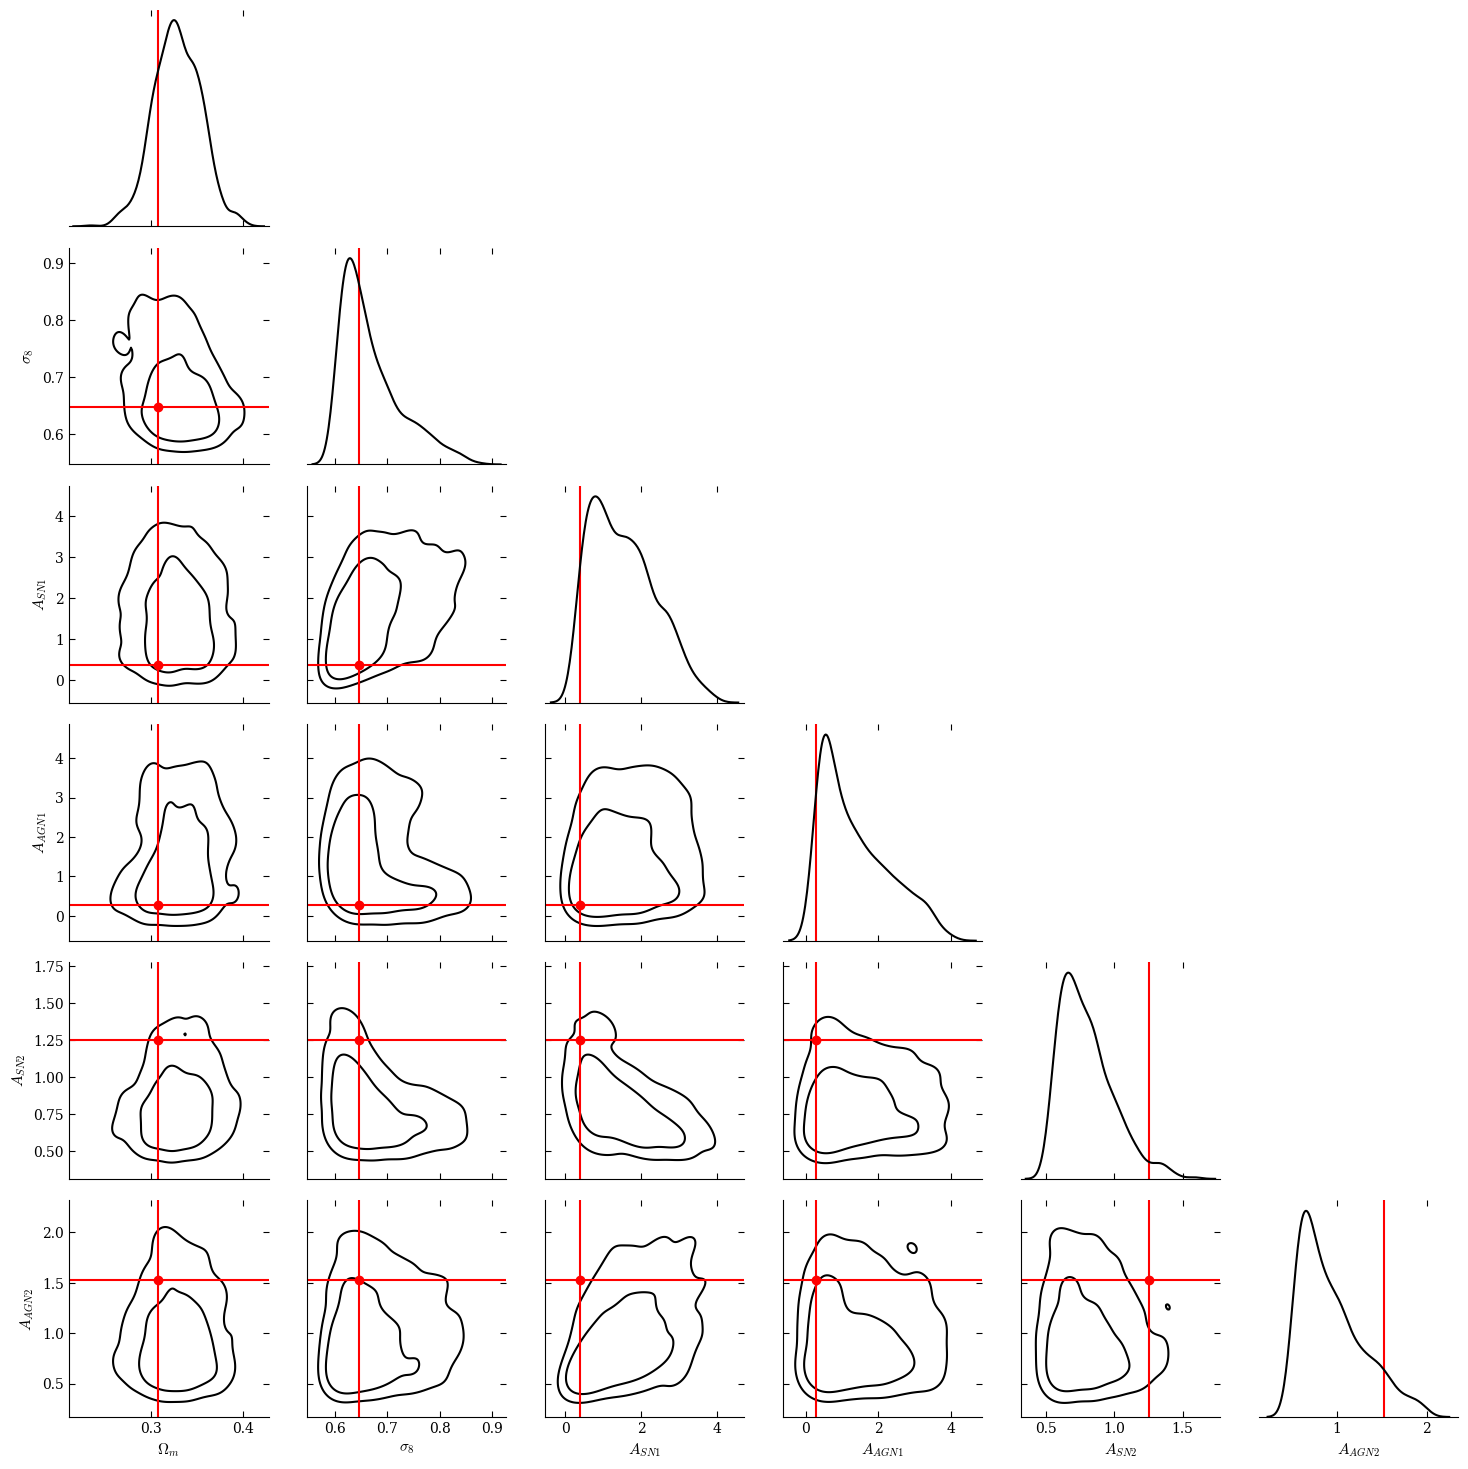

In [49]:
metric = PlotSinglePosterior(
    num_samples=1000, sample_method="direct", labels=labels, out_dir=None
)
fig = metric(
    posterior=posterior_ensemble_temp,
    x_obs=x_temp[ind],
    theta_fid=theta[ind],
)

100%|██████████| 1875/1875 [00:41<00:00, 45.29it/s]


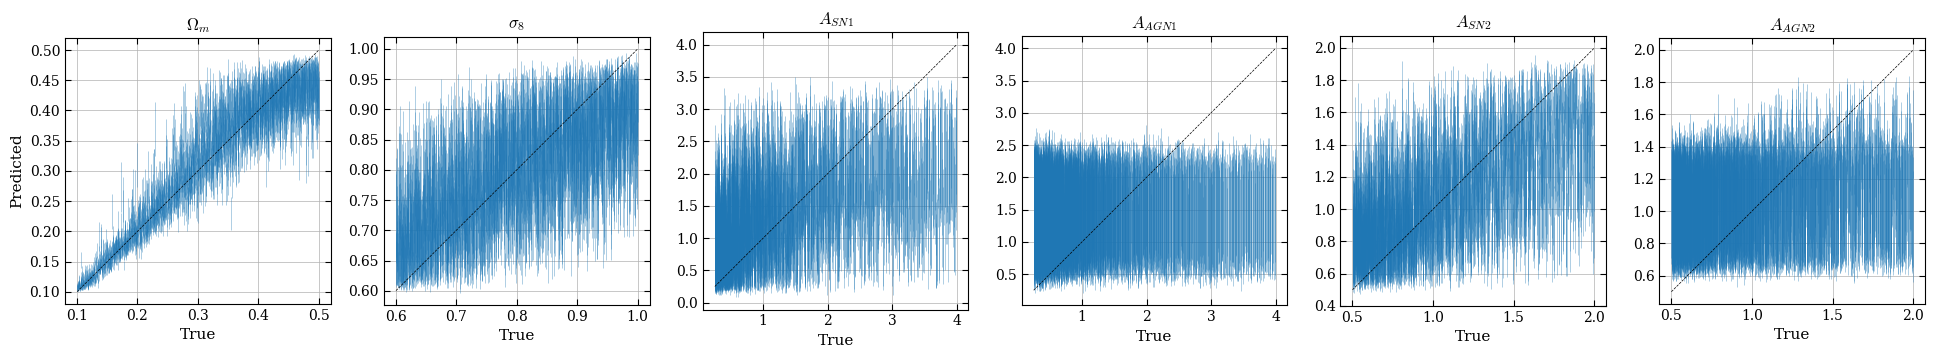

In [57]:
# calculate and plot the rank statistics to describe univariate posterior coverage
metric = PosteriorCoverage(
    num_samples=100, sample_method="direct", labels=labels, plot_list=["predictions"]
)
fig = metric(posterior=posterior_ensemble_temp, x=x_temp[::8], theta=theta[::8])
plt.savefig("./maf_predictions_temp.png", bbox_inches="tight", dpi=300, pad_inches=0.1)